In [23]:
import cv2
import pytesseract
import numpy as np
import matplotlib.pyplot as plt
import pytesseract

In [24]:
def find_and_crop_paper(img):

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 100)

    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)

    imgHeight, imgWidth = img.shape[:2]
    image_area = imgHeight * imgWidth
    bounding_rect_area = w * h

    if bounding_rect_area > (1/3) * image_area:
        cropped_img = img[y:y+h, x:x+w]
        return cropped_img

    return img

In [25]:
def resize(image, max_size):
    height, width = image.shape[:2]

    if width > height:
        new_width = max_size
        ratio = max_size / width
        new_height = int(height * (max_size / width))
    else:
        new_height = max_size
        ratio = max_size / height
        new_width = int(width * (max_size / height))
    resized_image = cv2.resize(image, (new_width, new_height))
    return resized_image, ratio

In [26]:
image = cv2.imread('../forms/form.png')
max_size = 3000

image = find_and_crop_paper(image)
resized_image, resize_ratio = resize(image, max_size)
drawImage = resized_image.copy()

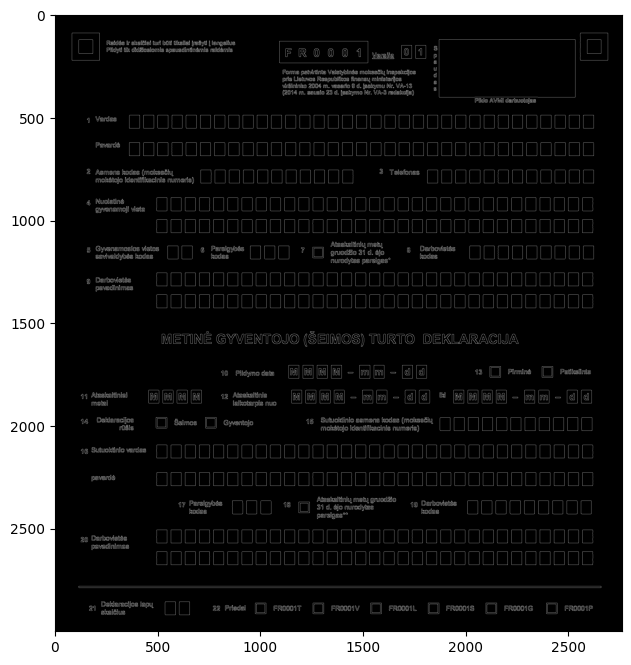

In [27]:
gray = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
edges = cv2.Canny(blurred, 5, 15)

cv2.imwrite('edges.png', edges)

plt.figure(figsize=(10, 8))
plt.imshow(edges, cmap='gray')
plt.show()

(604, 2857, 656, 2922)
(535, 2857, 587, 2922)
(771, 2616, 822, 2678)
(2567, 2613, 2619, 2678)
(2498, 2613, 2550, 2678)
(2429, 2613, 2480, 2679)
(2360, 2613, 2411, 2679)
(2291, 2613, 2342, 2679)
(2222, 2613, 2273, 2679)
(2152, 2613, 2204, 2679)
(2083, 2613, 2135, 2679)
(2014, 2613, 2066, 2678)
(1945, 2613, 1997, 2678)
(1876, 2613, 1928, 2678)
(1807, 2613, 1859, 2678)
(1738, 2613, 1790, 2678)
(1669, 2613, 1721, 2678)
(1600, 2613, 1652, 2678)
(1531, 2613, 1583, 2678)
(1462, 2613, 1514, 2678)
(1393, 2613, 1445, 2678)
(1324, 2613, 1375, 2678)
(1254, 2613, 1306, 2678)
(1185, 2613, 1237, 2678)
(1117, 2613, 1168, 2678)
(1047, 2613, 1099, 2678)
(978, 2613, 1030, 2678)
(909, 2613, 961, 2678)
(840, 2613, 892, 2678)
(702, 2613, 754, 2678)
(633, 2613, 684, 2678)
(564, 2613, 615, 2678)
(494, 2613, 546, 2679)
(2567, 2507, 2619, 2572)
(2498, 2507, 2550, 2572)
(2429, 2507, 2480, 2572)
(2291, 2507, 2342, 2572)
(2152, 2507, 2204, 2572)
(2083, 2507, 2135, 2572)
(2014, 2507, 2066, 2572)
(1945, 2507, 1997, 

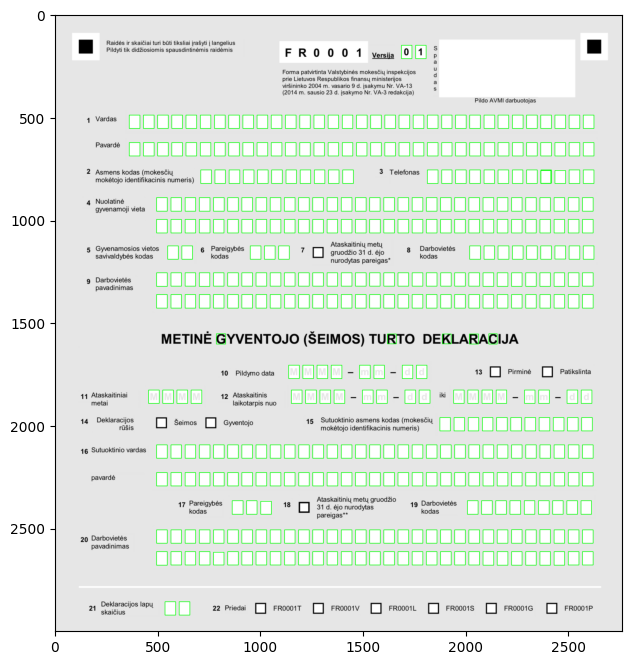

In [28]:
rectangles = []
contours, hierarchy = cv2.findContours(
    edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
last_children = []


def explore_hierarchy(contour_index, hierarchy, contours, last_children):
    if hierarchy[0][contour_index][2] != -1:
        child_index = hierarchy[0][contour_index][2]
        explore_hierarchy(child_index, hierarchy, contours, last_children)
    else:
        last_children.append(contours[contour_index])


for i, contour in enumerate(contours):
    x, y, w, h = cv2.boundingRect(contour)
    aspect_ratio = w / float(h)
    contour_area = w * float(h)
    if (0.7 <= aspect_ratio <= 0.9 and contour_area > 2000):
        rectangles.append((x, y, x + w, y + h))

imgdraw = drawImage.copy()

for rect in rectangles:
    x1, y1, x2, y2 = rect
    print(rect)
    cv2.rectangle(imgdraw, (x1, y1), (x2, y2), (0, 255, 0), 2)

plt.figure(figsize=(10, 8))
plt.imshow(imgdraw)
plt.show()

In [29]:
image = resized_image.copy()
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
edges = cv2.Canny(blurred, 50, 100)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
dilated_image = cv2.dilate(edges, kernel, iterations=1)

In [30]:
data = pytesseract.image_to_data(dilated_image, output_type=pytesseract.Output.DICT, config='--psm 11')

filtered_boxes = []
for i in range(len(data['level'])):
    (x, y, w, h) = (data['left'][i], data['top'][i], data['width'][i], data['height'][i])
    aspect_ratio = float(w) / h
    confidence = int(data['conf'][i])
    if 500 >= w * h:
        continue
    if 10 >= h:
        continue
    if 1.1 >= aspect_ratio:
        continue
    if 1 > confidence: 
        continue
    filtered_boxes.append((x, y, w, h))
    cv2.rectangle(image, (x, y), (x + w, y + h), (255, 0, 0), 2)

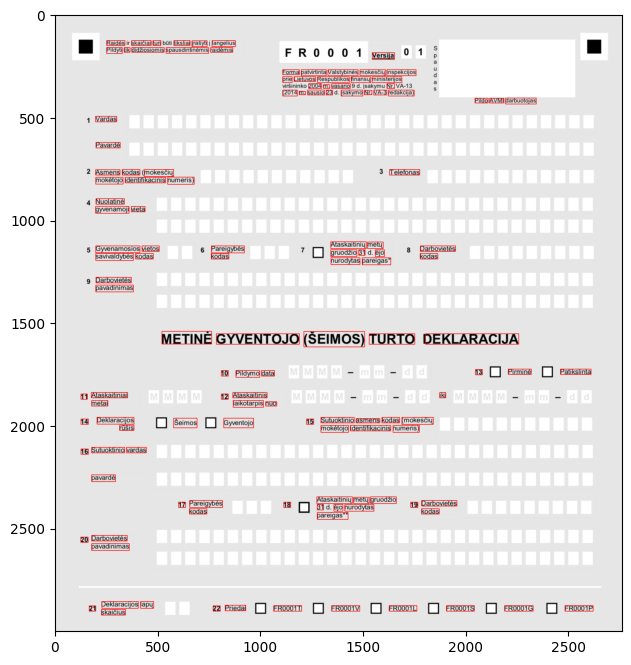

In [31]:
plt.figure(figsize=(10, 8))
plt.imshow(image, cmap='gray')
plt.show()

In [32]:
def intersects(element, box):
    line_x1, line_y1, line_x2, line_y2 = element
    box_x, box_y, box_w, box_h = box

    if (box_x <= line_x1 <= box_x + box_w and box_y <= line_y1 <= box_y + box_h) or \
       (box_x <= line_x2 <= box_x + box_w and box_y <= line_y2 <= box_y + box_h):
        return True


    return False  

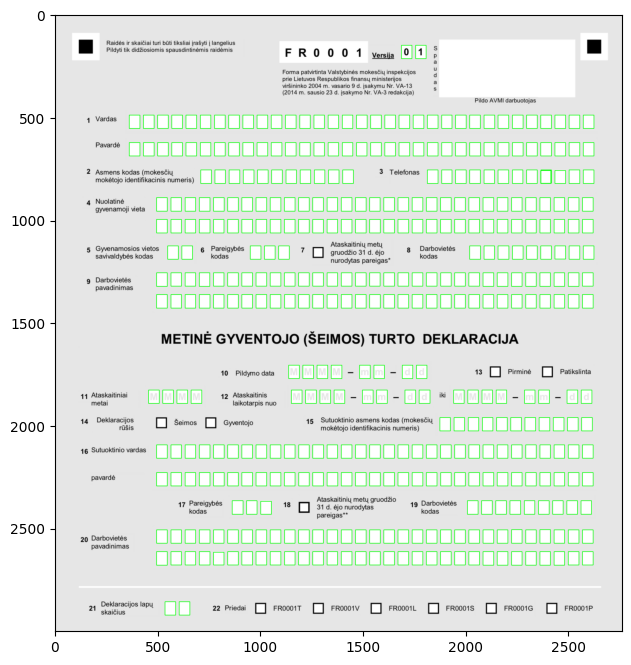

In [33]:
filtered_rects = []
for rect in rectangles:
    intersects_box = False
    for box in filtered_boxes:
        if intersects(rect, box):
            intersects_box = True
            break

    if not intersects_box:
        filtered_rects.append(rect)


# for line in aggregated_lines:
#     x1, y1, x2, y2 = line
#     intersects_box = False
#     for box in filtered_boxes:
#         if line_intersects_box(line, box):
#             intersects_box = True
#             break

#     if not intersects_box:
#         print(line)
#         cv2.line(resized_image, (x1, y1), (x2, y2), (0, 0, 255), 2)


drawImage = resized_image.copy()
for rect in filtered_rects:
    x1, y1, x2, y2 = rect
    # x1, y1, x2, y2 = map(lambda coord: int(coord / resize_ratio), rect)
    cv2.rectangle(drawImage, (x1, y1), (x2, y2), (0, 255, 0), 2)


plt.figure(figsize=(10, 8))
plt.imshow(drawImage)
plt.show()